In [ ]:
print("Data cleaning")

import pandas as pd
import numpy as np

# -----------------------------
# 0. Load Dataset
# -----------------------------
df = pd.read_csv("ola.csv")

# -----------------------------
# 1. Datetime Processing
# -----------------------------
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])  # remove corrupted datetime rows
df = df.sort_values('datetime').reset_index(drop=True)  # sort by datetime

# -----------------------------
# 2. Cleaning Physical Features
# -----------------------------
# Temperature: valid -30 to 60
df['temp'] = df['temp'].apply(lambda x: x if -30 <= x <= 60 else np.nan)

# Humidity: 0–100%
df['humidity'] = df['humidity'].apply(lambda x: x if 0 <= x <= 100 else np.nan)

# Windspeed: 0–150
df['windspeed'] = df['windspeed'].apply(lambda x: x if 0 <= x <= 150 else np.nan)

# -----------------------------
# 3. Fix Negative Counts
# -----------------------------
df['count'] = df['count'].clip(lower=0)
df['casual'] = df['casual'].clip(lower=0)
df['registered'] = df['registered'].clip(lower=0)

# -----------------------------
# 4. Handle Missing Values
# -----------------------------
# Use forward-fill/backward-fill for missing weather data
for col in ['temp','humidity','windspeed']:
    df[col] = df[col].interpolate(method='linear')  # simple linear interpolation
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')  # fill start/end NaNs

# -----------------------------
# 5. Remove Duplicates
# -----------------------------
df = df.drop_duplicates(subset=['datetime'])

# -----------------------------
# 6. Feature Engineering (Datetime Columns)
# -----------------------------
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.dayofweek

# -----------------------------
# 7. Final Check & Save
# -----------------------------
print("Cleaned dataset head:")
print(df.head())

print("\nColumns after cleaning:")
print(df.columns)

# Save cleaned dataset with datetime as a column
df.to_csv("cleaned_data.csv", index=False)
print("✅ Cleaned dataset saved with datetime column as cleaned_data.csv")

#Summary statistics
print("\nSummary statistics:")
df.describe().T

Data cleaning
Cleaned dataset head:
             datetime  season  weather       temp   humidity  windspeed  \
0 2011-01-01 00:00:00       3        2   7.653428  77.583743  18.783703   
1 2011-01-01 01:00:00       4        3  13.269244  77.583743  14.035245   
2 2011-01-01 02:00:00       1        3  30.886922  77.583743  45.365080   
3 2011-01-01 03:00:00       3        1  10.463377  79.324028  25.347168   
4 2011-01-01 04:00:00       3        4  30.214783  81.064313  20.288982   

   casual  registered       count  hour  day  month  day_of_week  
0       5         128  315.731778     0    1      1            5  
1      36         184  340.457093     1    1      1            5  
2      34          97  224.278595     2    1      1            5  
3       6          47  132.169549     3    1      1            5  
4      14         199  315.867137     4    1      1            5  

Columns after cleaning:
Index(['datetime', 'season', 'weather', 'temp', 'humidity', 'windspeed',
       'casua

/tmp/ipython-input-2996715713.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')  # fill start/end NaNs


✅ Cleaned dataset saved with datetime column as cleaned_data.csv

Summary statistics:


,count,mean,min,25%,50%,75%,max,std
datetime,10886,2011-08-15 18:30:00,2011-01-01 00:00:00,2011-04-24 09:15:00,2011-08-15 18:30:00,2011-12-07 03:45:00,2012-03-29 13:00:00,NaN
season,10886.0,2.493937,1.0,1.0,2.0,3.0,4.0,1.120531
weather,10886.0,2.491916,1.0,1.0,2.0,4.0,4.0,1.123139
temp,10886.0,20.429927,-22.743852,12.605872,20.35707,28.240452,58.987281,11.256111
humidity,10886.0,84.035883,32.713561,75.783142,88.419483,95.30281,99.981069,13.729302
windspeed,10886.0,31.59474,0.022621,18.633639,30.451312,42.631685,149.482842,17.830787
casual,10886.0,24.517545,0.0,12.0,25.0,37.0,49.0,14.390014
registered,10886.0,99.551442,0.0,50.0,100.0,149.0,199.0,57.541131
count,10886.0,224.178871,0.0,170.140221,224.257587,278.407366,464.839068,75.223709
hour,10886.0,11.49357,0.0,5.0,11.0,17.0,23.0,6.921882


In [ ]:
print("Feature Engineering with Synthetic Location Zones")
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import holidays

# Load cleaned dataset
df = pd.read_csv("cleaned_data.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

# -----------------------------
# 1. Time-based Features
# -----------------------------
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.dayofweek

# -----------------------------
# 2. Season Feature
# -----------------------------
# Already numeric, no change needed

# -----------------------------
# 3. Holiday Feature
# -----------------------------
ind_holidays = holidays.India(years=df['datetime'].dt.year.unique())
df['is_holiday'] = df['datetime'].dt.date.apply(lambda x: 1 if x in ind_holidays else 0)

# -----------------------------
# 4. Optional: Interaction Features
# -----------------------------
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 7 <= x <= 10 or 17 <= x <= 20 else 0)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# -----------------------------
# 5. Create Synthetic Location Zones
# -----------------------------
# Features for clustering: time + weather + count
zone_features = df[['hour', 'day_of_week', 'temp', 'humidity', 'windspeed', 'count']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(zone_features)

# KMeans to create 4 synthetic zones
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['location_zone_label'] = kmeans.fit_predict(X_scaled)

# One-hot encode zones
df = pd.get_dummies(df, columns=['location_zone_label'], prefix='zone')

# -----------------------------
# 6. Final Check
# -----------------------------
print("Feature engineered dataset head:")
print(df.head())

print("\nColumns:")
print(df.columns)

# Save the dataset
df.to_csv("feature_engineered_data_pattern_location.csv", index=False)
print("✅ Feature engineered dataset saved as feature_engineered_data_pattern_location.csv")

# Summary statistics
print("\nSummary statistics:")
df.describe().T


Feature Engineering with Synthetic Location Zones
Feature engineered dataset head:
             datetime  season  weather       temp   humidity  windspeed  \
0 2011-01-01 00:00:00       3        2   7.653428  77.583743  18.783703   
1 2011-01-01 01:00:00       4        3  13.269244  77.583743  14.035245   
2 2011-01-01 02:00:00       1        3  30.886922  77.583743  45.365080   
3 2011-01-01 03:00:00       3        1  10.463377  79.324028  25.347168   
4 2011-01-01 04:00:00       3        4  30.214783  81.064313  20.288982   

   casual  registered       count  hour  day  month  day_of_week  is_holiday  \
0       5         128  315.731778     0    1      1            5           0   
1      36         184  340.457093     1    1      1            5           0   
2      34          97  224.278595     2    1      1            5           0   
3       6          47  132.169549     3    1      1            5           0   
4      14         199  315.867137     4    1      1            5  

,count,mean,min,25%,50%,75%,max,std
datetime,10886,2011-08-15 18:30:00,2011-01-01 00:00:00,2011-04-24 09:15:00,2011-08-15 18:30:00,2011-12-07 03:45:00,2012-03-29 13:00:00,NaN
season,10886.0,2.493937,1.0,1.0,2.0,3.0,4.0,1.120531
weather,10886.0,2.491916,1.0,1.0,2.0,4.0,4.0,1.123139
temp,10886.0,20.429927,-22.743852,12.605872,20.35707,28.240452,58.987281,11.256111
humidity,10886.0,84.035883,32.713561,75.783142,88.419483,95.30281,99.981069,13.729302
windspeed,10886.0,31.59474,0.022621,18.633639,30.451312,42.631685,149.482842,17.830787
casual,10886.0,24.517545,0.0,12.0,25.0,37.0,49.0,14.390014
registered,10886.0,99.551442,0.0,50.0,100.0,149.0,199.0,57.541131
count,10886.0,224.178871,0.0,170.140221,224.257587,278.407366,464.839068,75.223709
hour,10886.0,11.49357,0.0,5.0,11.0,17.0,23.0,6.921882


Model Training & Evaluation (Pattern + Location + Interactions)
LinearRegression → RMSE: 72.72, R2: -0.113
RandomForest → RMSE: 66.50, R2: 0.069
XGBoost → RMSE: 69.15, R2: -0.006


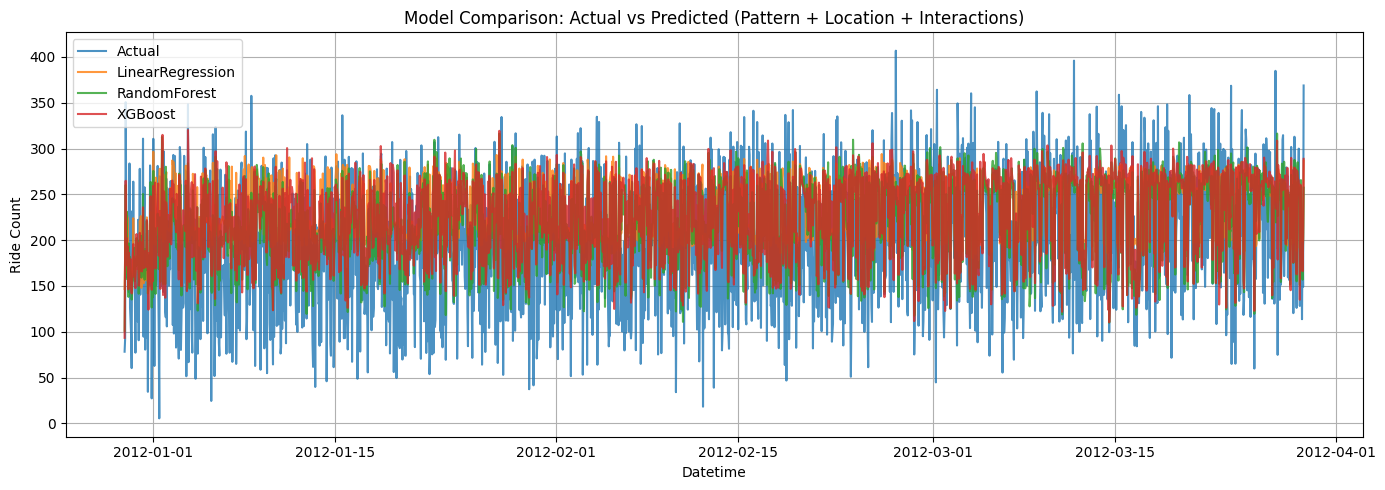

<Figure size 640x480 with 0 Axes>

In [ ]:
print("Model Training & Evaluation (Pattern + Location + Interactions)")

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Enhanced Dataset
# -----------------------------
df = pd.read_csv("feature_engineered_data_pattern_location.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

# -----------------------------
# 2. Create Interaction Features
# -----------------------------
# Time × Zone
for i in range(4):
    df[f'hour_zone_{i}'] = df['hour'] * df[f'zone_{i}']

# Weather × Zone
for i, w in enumerate(['temp', 'humidity', 'windspeed']):
    df[f'{w}_zone'] = df[w] * df[[f'zone_0', f'zone_1', f'zone_2', f'zone_3']].idxmax(axis=1).str.replace('zone_','').astype(int)

# Holiday × Peak Hour
df['holiday_peak'] = df['is_holiday'] * df['is_peak_hour']

# -----------------------------
# 3. Define Features & Target
# -----------------------------
feature_cols = [
    'hour', 'day_of_week', 'month',
    'temp', 'humidity', 'windspeed',
    'is_holiday', 'is_peak_hour', 'is_weekend',
    'zone_0', 'zone_1', 'zone_2', 'zone_3',
    'hour_zone_0', 'hour_zone_1', 'hour_zone_2', 'hour_zone_3',
    'temp_zone', 'humidity_zone', 'windspeed_zone',
    'holiday_peak'
]

X = df[feature_cols]
y = df['count']

# -----------------------------
# 4. Chronological Train-Test Split
# -----------------------------
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# -----------------------------
# 5. Define Models
# -----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
}

results = {}

# -----------------------------
# 6. Train & Evaluate
# -----------------------------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2": r2}
    print(f"{name} → RMSE: {rmse:.2f}, R2: {r2:.3f}")

# -----------------------------
# 7. Visual Comparison
# -----------------------------
plt.figure(figsize=(14,5))
plt.plot(df['datetime'].iloc[train_size:], y_test, label='Actual', alpha=0.8)

for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.plot(df['datetime'].iloc[train_size:], y_pred, alpha=0.8, label=name)

plt.xlabel("Datetime")
plt.ylabel("Ride Count")
plt.title("Model Comparison: Actual vs Predicted (Pattern + Location + Interactions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("feature_engineered_data_pattern_location_interactions.png", dpi=300)


In [ ]:
print("Forecast Model")
import joblib

# Choose best model based on RMSE (RandomForest in your case)
best_model = models['RandomForest']

# Save the model
joblib.dump(best_model, "ride_demand_forecast_model.pkl")
print("✅ Forecast model saved as ride_demand_forecast_model.pkl")


Forecast Model
✅ Forecast model saved as ride_demand_forecast_model.pkl


In [ ]:
print("Peak Hour Insights")
import pandas as pd

# Use best model to predict on test set
y_pred = best_model.predict(X_test)

# Create a DataFrame with datetime and predictions
pred_df = pd.DataFrame({
    'datetime': df['datetime'].iloc[train_size:],
    'predicted_count': y_pred
})

# Extract hour and day_of_week
pred_df['hour'] = pred_df['datetime'].dt.hour
pred_df['day_of_week'] = pred_df['datetime'].dt.dayofweek

# Average predicted rides by hour
hourly_avg = pred_df.groupby('hour')['predicted_count'].mean()
print("\n📊 Average Predicted Ride Count by Hour:")
print(hourly_avg)

# Identify peak hours
peak_hours = hourly_avg.sort_values(ascending=False).head(5)
print("\n🔥 Top 5 Peak Hours:")
print(peak_hours)


Peak Hour Insights

📊 Average Predicted Ride Count by Hour:
hour
0     220.347480
1     230.200739
2     228.159408
3     214.558442
4     217.625951
5     214.785183
6     208.731995
7     209.606862
8     221.124580
9     213.545235
10    221.446433
11    211.053967
12    211.442897
13    215.201367
14    219.101069
15    220.188604
16    220.500435
17    218.149352
18    220.835122
19    210.992291
20    230.028297
21    225.964449
22    230.631117
23    223.240580
Name: predicted_count, dtype: float64

🔥 Top 5 Peak Hours:
hour
22    230.631117
1     230.200739
20    230.028297
2     228.159408
21    225.964449
Name: predicted_count, dtype: float64


Graphs & Predictions


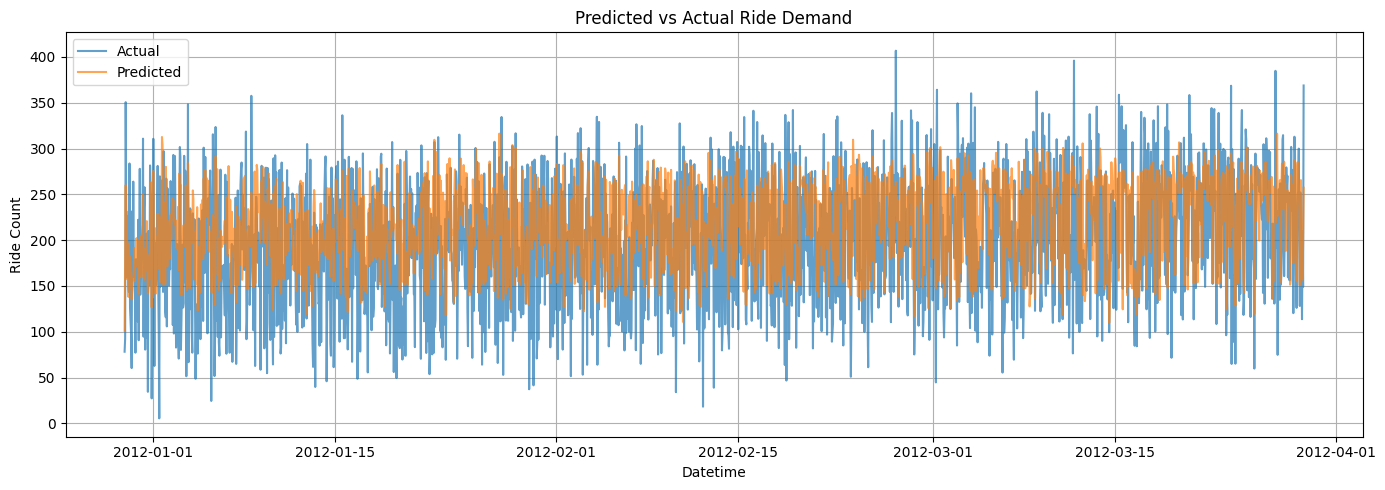

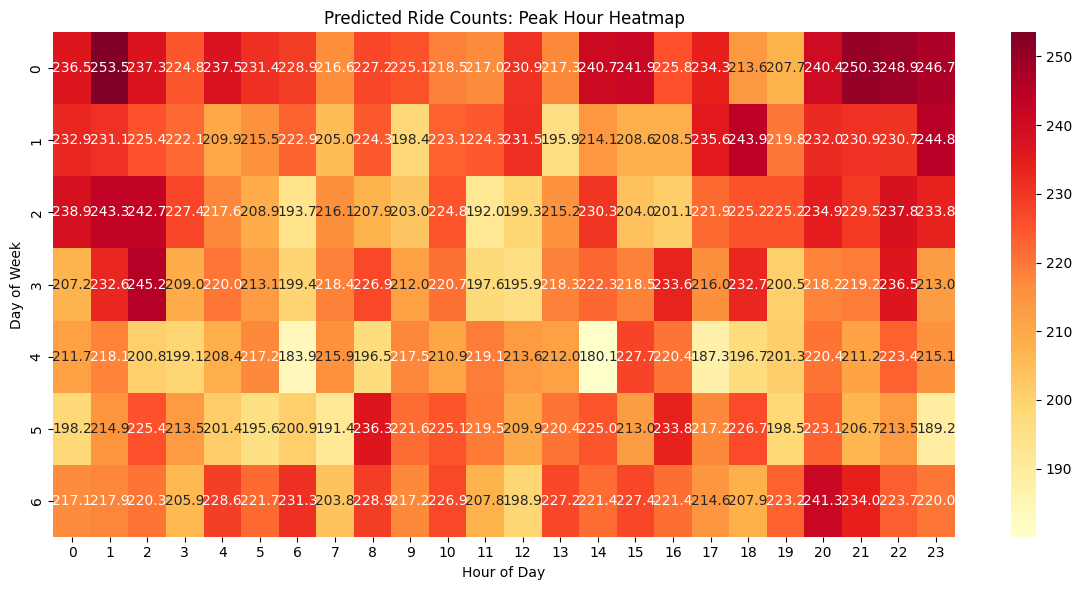

✅ Predictions saved as predicted_ride_counts.csv


In [ ]:
print("Graphs & Predictions")
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(pred_df['datetime'], y_test.values, label='Actual', alpha=0.7)
plt.plot(pred_df['datetime'], y_pred, label='Predicted', alpha=0.7)
plt.xlabel("Datetime")
plt.ylabel("Ride Count")
plt.title("Predicted vs Actual Ride Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("predicted_vs_actual.png", dpi=300)
plt.show()

import seaborn as sns

heatmap_data = pred_df.groupby(['day_of_week','hour'])['predicted_count'].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Predicted Ride Counts: Peak Hour Heatmap")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.savefig("peak_hour_heatmap.png", dpi=300)
plt.show()

pred_df.to_csv("predicted_ride_counts.csv", index=False)
print("✅ Predictions saved as predicted_ride_counts.csv")


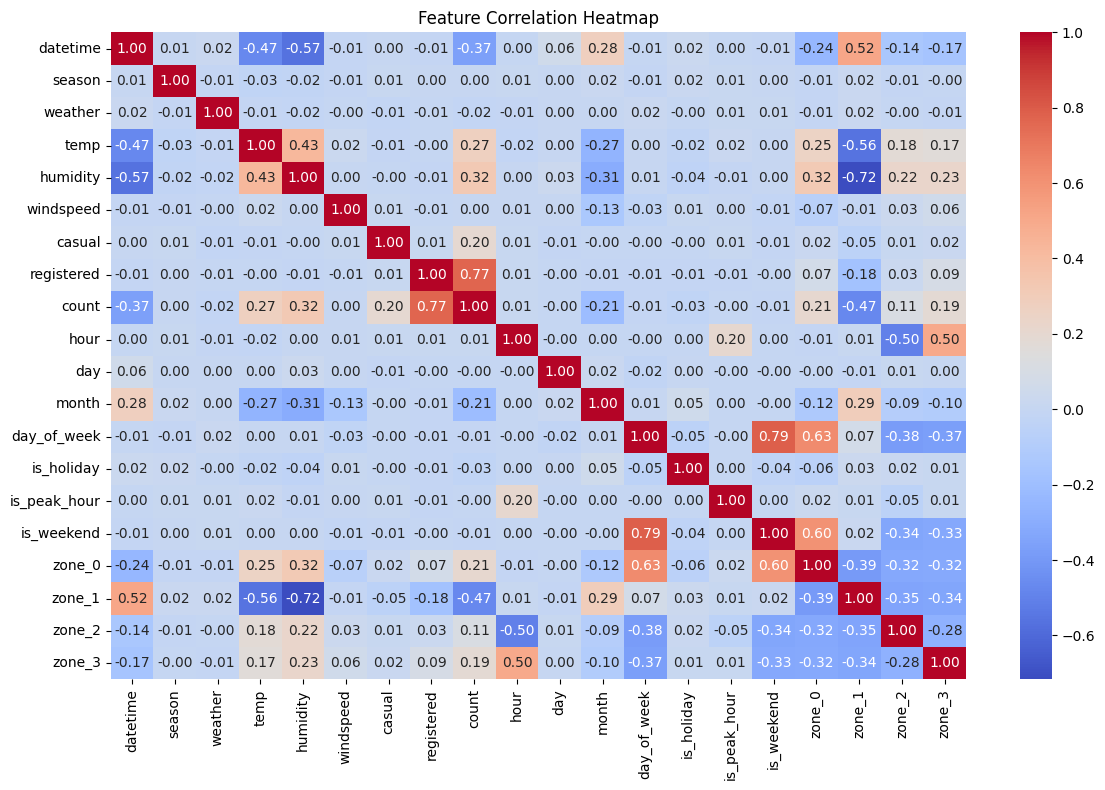

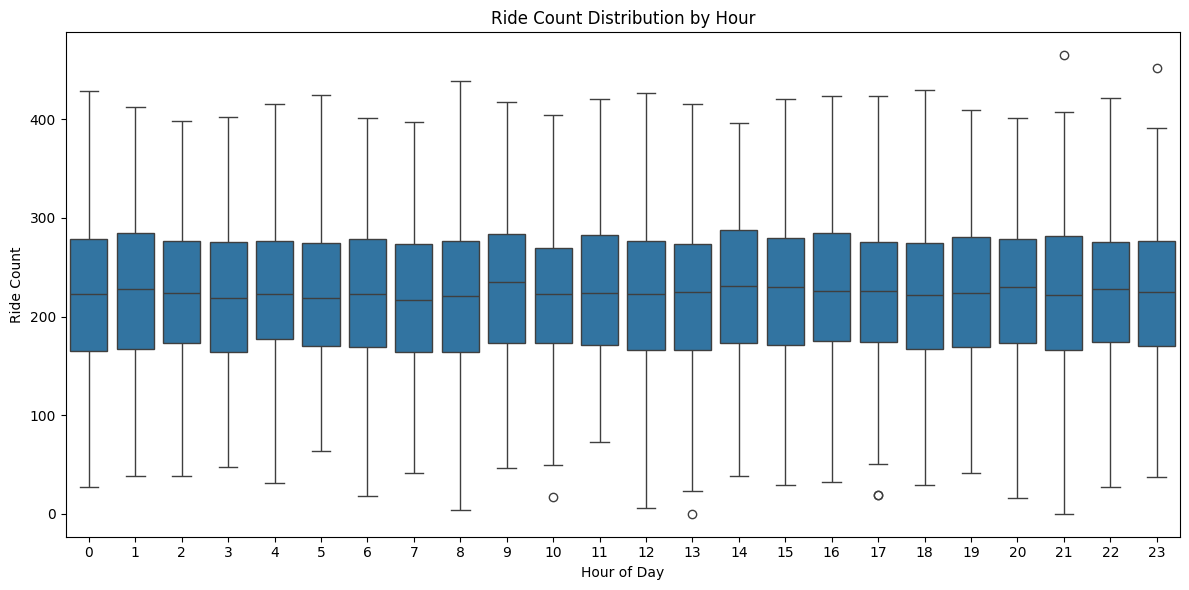

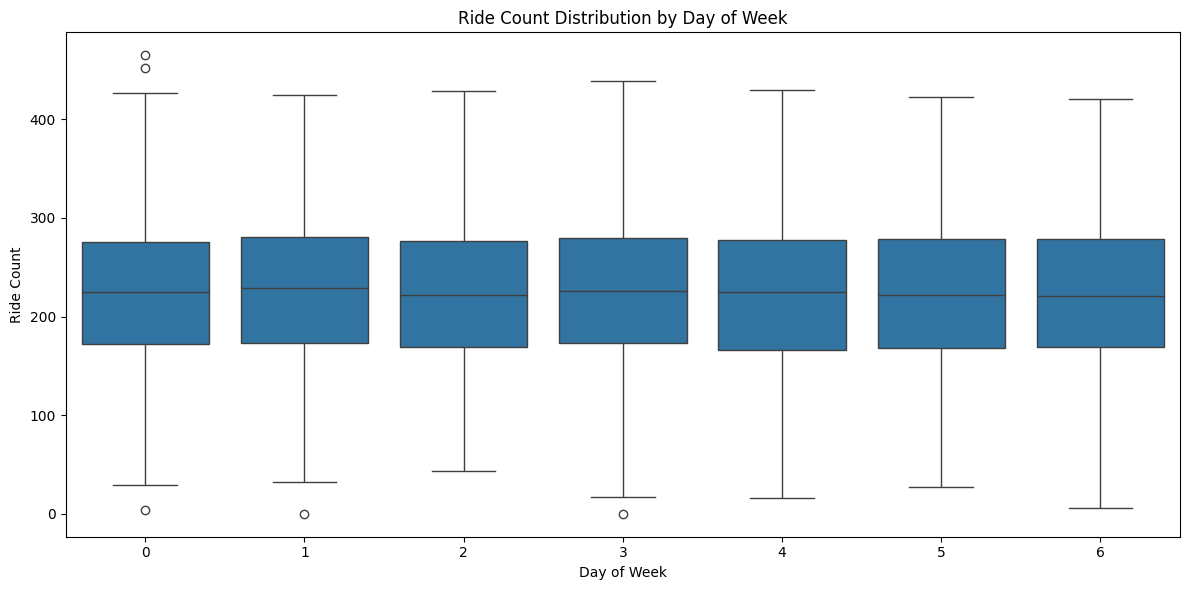

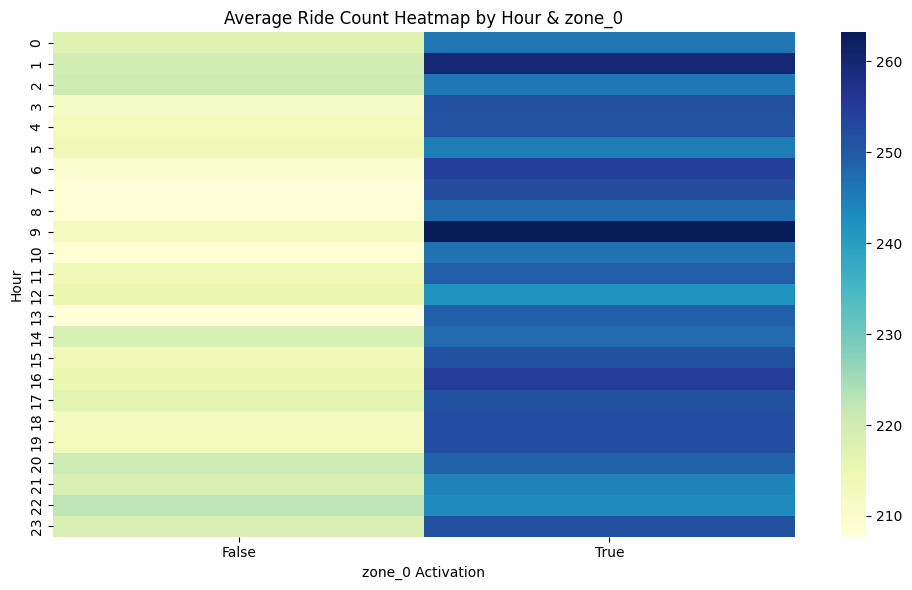

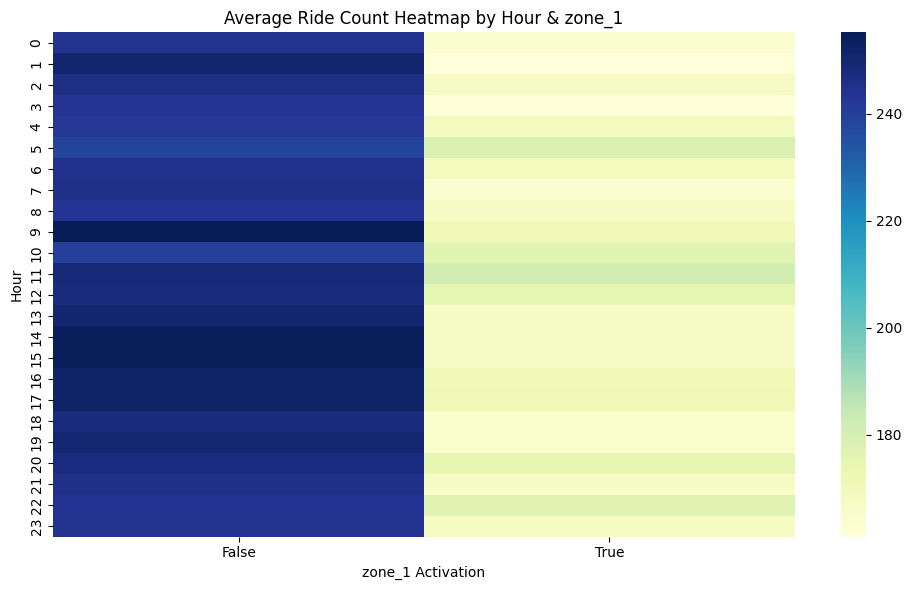

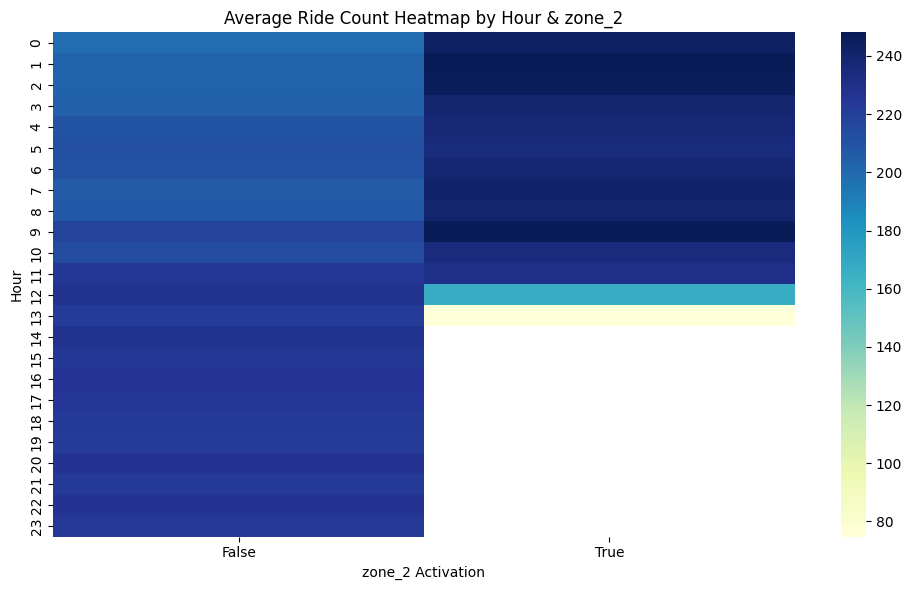

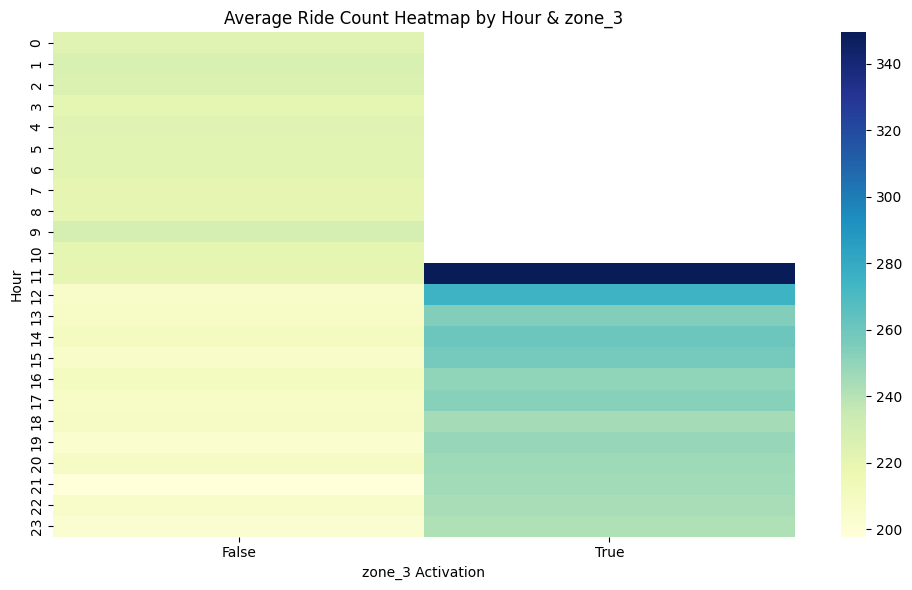

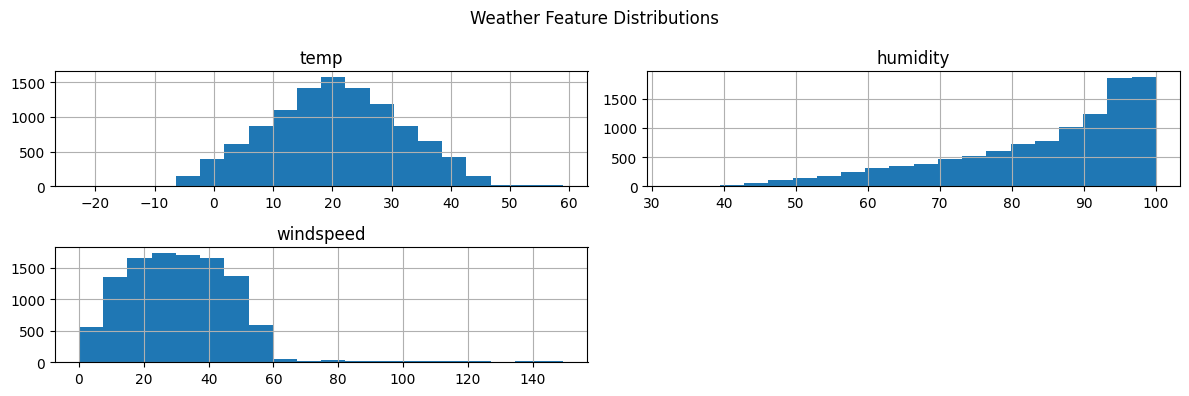

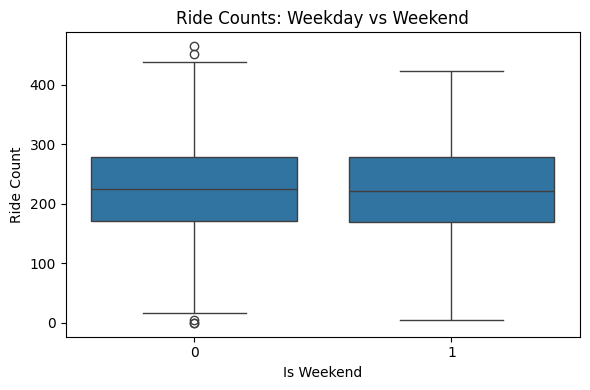

All EDA plots generated and saved as PNG files.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load Data
# -----------------------------
df = pd.read_csv("feature_engineered_data_pattern_location.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# -----------------------------
# 2. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("eda_correlation_heatmap.png", dpi=300)
plt.show()

# -----------------------------
# 3. Boxplots of Ride Counts by Hour
# -----------------------------
plt.figure(figsize=(12,6))
sns.boxplot(x='hour', y='count', data=df)
plt.title("Ride Count Distribution by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Ride Count")
plt.tight_layout()
plt.savefig("eda_boxplot_hour.png", dpi=300)
plt.show()

# -----------------------------
# 4. Boxplots of Ride Counts by Day of Week
# -----------------------------
plt.figure(figsize=(12,6))
sns.boxplot(x='day_of_week', y='count', data=df)
plt.title("Ride Count Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Ride Count")
plt.tight_layout()
plt.savefig("eda_boxplot_dow.png", dpi=300)
plt.show()

# -----------------------------
# 5. Peak Hour Heatmaps by Zone
# -----------------------------
for i in range(4):
    zone_col = f'zone_{i}'
    # create pivot table (average count by hour and zone activation)
    peak_matrix = df.pivot_table(values='count', index='hour', columns=zone_col, aggfunc='mean')
    plt.figure(figsize=(10,6))
    sns.heatmap(peak_matrix, cmap="YlGnBu")
    plt.title(f"Average Ride Count Heatmap by Hour & {zone_col}")
    plt.xlabel(f"{zone_col} Activation")
    plt.ylabel("Hour")
    plt.tight_layout()
    plt.savefig(f"eda_peak_hour_{zone_col}.png", dpi=300)
    plt.show()

# -----------------------------
# 6. Weather Feature Distributions
# -----------------------------
weather_features = ['temp','humidity','windspeed']
df[weather_features].hist(figsize=(12,4), bins=20)
plt.suptitle("Weather Feature Distributions")
plt.tight_layout()
plt.savefig("eda_weather_distributions.png", dpi=300)
plt.show()

# -----------------------------
# 7. Weekend vs Weekday Ride Counts
# -----------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x='is_weekend', y='count', data=df)
plt.title("Ride Counts: Weekday vs Weekend")
plt.xlabel("Is Weekend")
plt.ylabel("Ride Count")
plt.tight_layout()
plt.savefig("eda_weekend_vs_weekday.png", dpi=300)
plt.show()

print("All EDA plots generated and saved as PNG files.")
